In [296]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from platypus.core import *
from platypus.types import *
from platypus.algorithms import *
from z0_util import cal_vap_sat, cal_dens_dry, cal_dens_vap, cal_cpa, cal_dens_air, cal_Lob
import pickle

In [292]:
# specify the site name
name_of_site = 'US-MMS'
years=[2010,2012,2016]


def read_prepare(name_of_site,years):
    
    
    df_attr=pd.read_csv('all_attrs.csv')

    # load dataset
    
    if name_of_site in ['CN-DNT-rice','CN-DNT-wheat']:

        df_data=pd.read_csv('data/Crop/all_date.csv',index_col=0,parse_dates=True)
        df_data=df_data[(df_data['WS']!=0)]
        bb=pd.DataFrame(~np.isin(df_data.index.date,df_data[df_data.P!=0].index.date))
        bb.index=df_data.index
        df_data=df_data[bb.values]
        
        if name_of_site=='CN-DNT-rice':
            date_0=datetime.datetime(2016,6,16)
            date_1=datetime.datetime(2016,11,5)
            z_meas=df_attr[df_attr.site=='cropr'].meas.values[0]
            h_sfc=df_zmeas=df_attr[df_attr.site=='cropr'].height.values[0]
        else:
            date_0=datetime.datetime(2014,12,15)
            date_1=datetime.datetime(2015,5,31)
            z_meas=df_attr[df_attr.site=='cropw'].meas.values[0]
            h_sfc=df_zmeas=df_attr[df_attr.site=='cropw'].height.values[0]

        df_years=df_data.loc[date_0:date_1]


    elif name_of_site=='PH-IRI':
        df_data=pd.read_csv('data/Crop/IRI/all_data.csv',index_col=0,parse_dates=True)
        df_data=df_data.rename(columns={'Ta':'TA','USt':'USTAR','Rh':'RH'})
        df_data['PA']=1010
        date_0=datetime.datetime(2013,6,27)
        date_1=datetime.datetime(2013,10,22)
        z_meas=df_attr[df_attr.site=='IRI'].meas.values[0]
        h_sfc=df_zmeas=df_attr[df_attr.site=='IRI'].height.values[0]
        df_years=df_data.loc[date_0:date_1]
        
    else:
        z_meas=df_attr[df_attr.site==name_of_site].meas.values[0]
        h_sfc=df_zmeas=df_attr[df_attr.site==name_of_site].height.values[0]
        folder='data/data_csv_zip_clean_new/'
        site_file = folder+'/'+name_of_site + '_clean.csv.gz'
        df_data = pd.read_csv(site_file, index_col='time', parse_dates=['time'])
        # Rain
        bb=pd.DataFrame(~np.isin(df_data.index.date,df_data[df_data.P!=0].index.date))
        bb.index=df_data.index
        df_data=df_data[bb.values]
        
        if name_of_site=='US-Blk':
            df_data=df_data[df_data.USTAR>=0.25]
        else:
            df_data=df_data[df_data.USTAR!=0]
            
        df_data=df_data[(df_data['WS']!=0)]

        df_years=df_data.loc[f'{years[0]}']
        for i in years[1:]:
            df_years=df_years.append(df_data.loc[f'{i}'])
        
    # select valid values
    df_val = df_years.loc[:, ['H', 'USTAR', 'TA', 'RH', 'PA', 'WS']].dropna()

    # calculate Obukhov length
    ser_Lob = df_val.apply(
        lambda ser: cal_Lob(ser.H, ser.USTAR, ser.TA, ser.RH, ser.PA * 10), axis=1)

    # zero-plane displacement: estimated using rule f thumb `d=0.7*h_sfc`

    z_d = 0.7 * h_sfc

    if z_d >= z_meas:
        print(
            'vegetation height is greater than measuring height. Please fix this before continuing'
        )

    # calculate stability scale
    ser_zL = (z_meas - z_d) / ser_Lob
    
    # determine periods under quasi-neutral conditions
    limit_neutral = 0.01
    ind_neutral = ser_zL.between(-limit_neutral, limit_neutral)

    ind_neutral=ind_neutral[ind_neutral==True]

    # season='summer'
    # if season=='summer':
    #     d1=(ind_neutral.index.month==6)|(ind_neutral.index.month==7)|(ind_neutral.index.month==8)
    # elif season=='winter':
    #     d1=(ind_neutral.index.month==12)|(ind_neutral.index.month==1)|(ind_neutral.index.month==2)
    # ind_neutral=ind_neutral[d1]
    # choose the necessary variables

    df_sel = df_val.loc[ind_neutral.index, ['WS', 'USTAR']].dropna()
    ser_ustar = df_sel.USTAR
    ser_ws = df_sel.WS

    
    
    def func_uz(params):
        z0=params[0]
        d=params[1]
        z = z_meas
        k = 0.4
        uz = (ser_ustar / k) * np.log((z - d) / z0)

        o1=abs(1-np.std(uz)/np.std(ser_ws))
        o2=np.mean(abs(uz-ser_ws))/(np.mean(ser_ws))
        #o2=np.mean((uz-ser_ws))/(np.mean(ser_ws))

        return [o1,o2],[uz.min(),d-z0]
    
    problem = Problem(2,2,2)
    problem.types[0] = Real(0, 10)
    problem.types[1] = Real(0, h_sfc)


    problem.constraints[0] = ">=0"
    problem.constraints[1] = ">=0"

    problem.function = func_uz
    random.seed(12345)
    #algorithm=CMAES(problem, epsilons=[0.005])
    algorithm=NSGAIII(problem, divisions_outer=50)
    algorithm.run(30000)
    
    return algorithm,z_meas,ser_ustar,ser_ws,h_sfc

In [316]:
names=['US-MMS','US-UMB','US-Oho','CA-Obs','CA-Qcu',
       'US-Blk','US-AR1','US-KUT','CN-DNT-rice','CN-DNT-wheat','PH-IRI']


years_all={names[0]:[2010,2012,2016],
       names[1]:[2010,2014],   # No 2016?
       names[2]:[2011,2012,2013],
       names[3]:[2003,2005,2006],
       names[4]:[2005,2008,2009],
       names[5]:[2004,2006,2008],
       names[6]:[2010,2011],
       names[7]:[2006,2007],
       names[8]:[2016],
       names[9]:[2014],
       names[10]:[2013]
      }

res={}
for name_of_site in names:
    res[name_of_site]={}
    years=years_all[name_of_site]
    print(name_of_site)
    
    algorithm,z_meas,ser_ustar,ser_ws,h_sfc=read_prepare(name_of_site,years)
    all_G={
          'g2':[],
          'g3':[],
          'g4':[],
          'g5':[],
          'g6':[]
          }
    a=[]
    z0s=[]
    ds=[]
    os1=[]
    os2=[]
    for s in algorithm.result:
        z0s.append(s.variables[0])
        ds.append(s.variables[1])
        os1.append(s.objectives[0])
        os2.append(s.objectives[1])

    def uz(z0,d):
        z = z_meas
        k = 0.4
        uz = (ser_ustar / k) * np.log((z - d) / z0)
        return uz



    idx=os2.index(np.min(os2))
    z0=np.mean(z0s[idx])
    d=np.mean(ds[idx])

    res[name_of_site]['z0s']=z0s
    res[name_of_site]['ds']=ds
    
    res[name_of_site]['z0']=z0
    res[name_of_site]['d']=d
    res[name_of_site]['ws_obs']=ser_ws
    res[name_of_site]['h_sfc']=h_sfc
    res[name_of_site]['ws_mod']=uz(z0,d)

US-MMS


/Users/hamidrezaomidvar/Desktop/SUEWS_parameters/z0_util.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  Lob = (uStar**2)/(G_T_K*TStar)


US-UMB
US-Oho
CA-Obs
CA-Qcu
US-Blk
US-AR1
US-KUT
CN-DNT-rice
CN-DNT-wheat
PH-IRI


In [317]:
with open('outputs/roughness/all_roughness.pkl','wb') as f:
    pickle.dump(res, f)

In [318]:
with open('outputs/roughness/all_roughness.pkl','rb') as f:
    res=pickle.load(f)

# Plotting

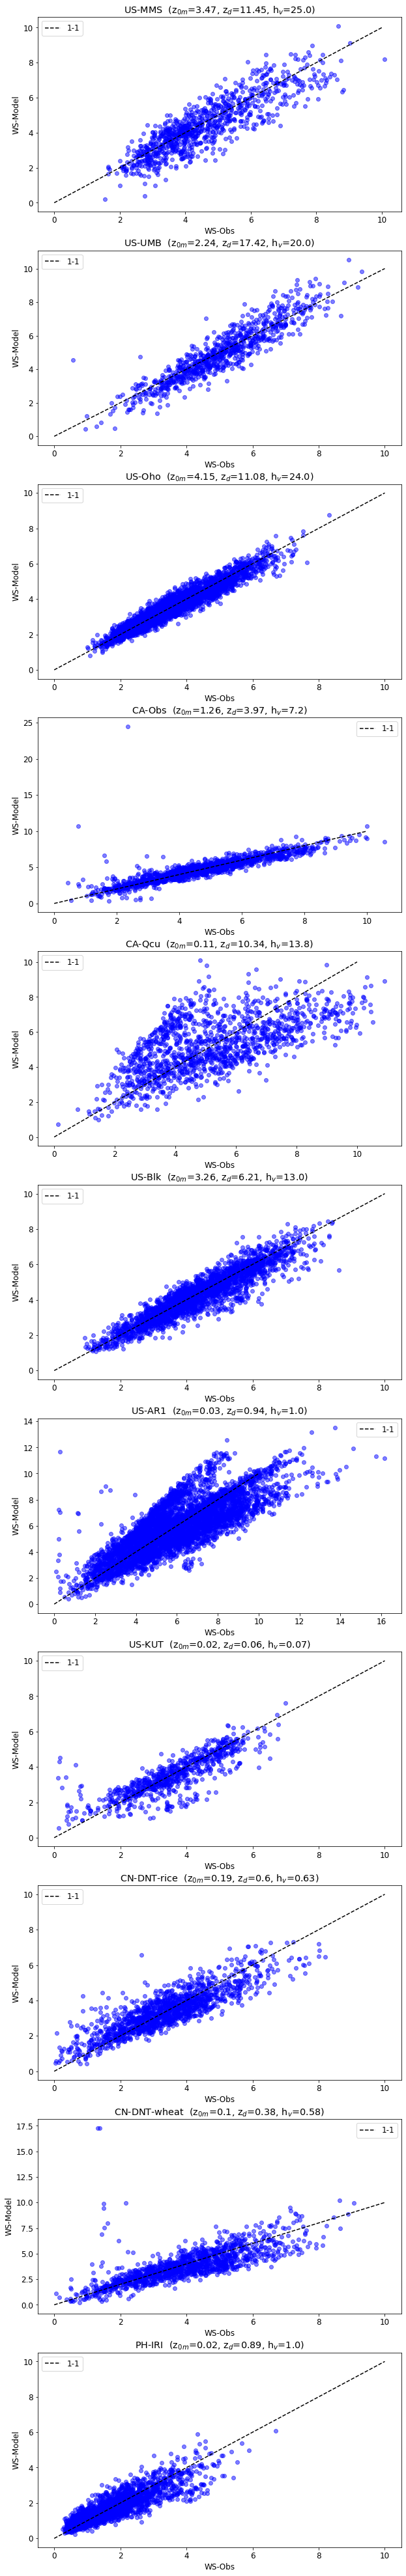

In [360]:
names=['US-MMS','US-UMB','US-Oho','CA-Obs','CA-Qcu',
       'US-Blk','US-AR1','US-KUT','CN-DNT-rice','CN-DNT-wheat','PH-IRI']


fig,axs=plt.subplots(len(names),1,figsize=(10,len(names)*6.5))

ratio_z0=[]
ratio_d=[]
for i,name in enumerate(names):
    z0=res[name]['z0']
    d=res[name]['d']
    h_sfc=res[name]['h_sfc']
    ser_ws=res[name]['ws_obs']
    ws_mod=res[name]['ws_mod']
    ratio_z0.append(z0/h_sfc)
    ratio_d.append(d/h_sfc)

    ax=axs[i]
    ax.scatter(ser_ws,ws_mod,color='b',alpha=0.5)
    ax.plot([0,10],[0,10],c='k',linestyle='--')
    ax.legend(['1-1'])
    ax.set_ylabel('WS-Model')
    ax.set_xlabel('WS-Obs')
    ax.set_title(name+'  (z$_{0m}$='+str(np.round(z0,2))+', z$_d$='+str(np.round(d,2))+', h$_v$='+str(h_sfc)+')')
    
plt.savefig('WS_obs_mod.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

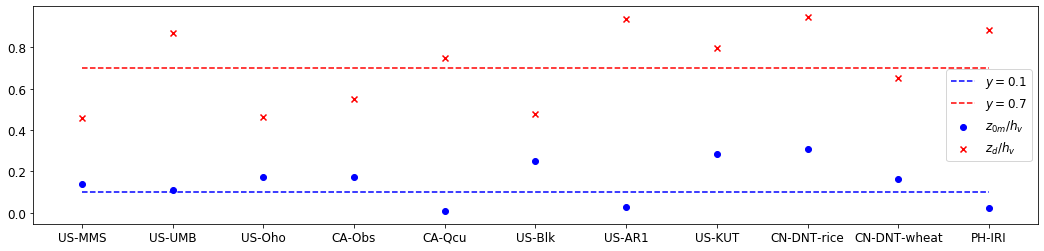

In [361]:
plt.rcParams.update({'font.size': 12})
fig,ax=plt.subplots(1,1,figsize=(18,4))


ax.scatter(names,ratio_z0,c='b',label='$z_{0m}/h_v$')
ax.plot(names,[.1 for x in names],color='b',linestyle='--',label='$y=0.1$')



ax.scatter(names,ratio_d,c='r',marker='x',label='$z_d/h_v$')
ax.plot(names,[.7 for x in names],color='r',linestyle='--',label='$y=0.7$')

ax.legend()

plt.savefig('z0_d.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

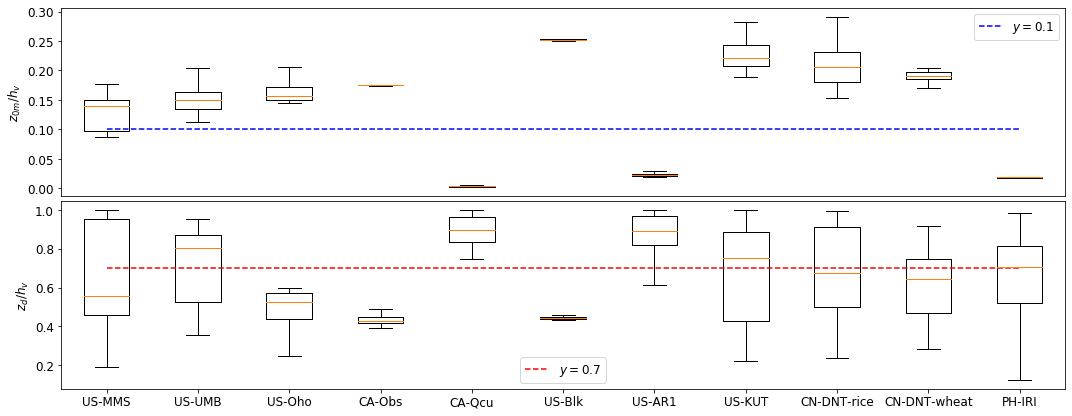

In [362]:
names=['US-MMS','US-UMB','US-Oho','CA-Obs','CA-Qcu',
       'US-Blk','US-AR1','US-KUT','CN-DNT-rice','CN-DNT-wheat','PH-IRI']

all_z0=[]
all_d=[]

plt.rcParams.update({'font.size': 12})
fig,axs=plt.subplots(2,1,figsize=(18,7))
plt.subplots_adjust(hspace=0.03)
for name in names:
    h_sfc=res[name]['h_sfc'] 
    all_z0.append(res[name]['z0s']/h_sfc)
    all_d.append(res[name]['ds']/h_sfc)


ax=axs[0]
ax.boxplot(all_z0,showfliers=False)
ax.plot([x+1 for x in range(len(names))],[.1 for x in names],color='b',linestyle='--',label='$y=0.1$')  
ax.set_ylabel('$z_{0m}/h_v$')
ax.legend()  
ax.axes.get_xaxis().set_visible(False)

ax=axs[1]
ax.boxplot(all_d,showfliers=False)
ax.plot([x+1 for x in range(len(names))],[.7 for x in names],color='r',linestyle='--',label='$y=0.7$')
ax.set_ylabel('$z_{d}/h_v$')
txt=ax.set_xticklabels([x for x in names])
ax.legend() 
plt.savefig('z0_d_box.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)